<a href="https://colab.research.google.com/github/Dolewma/retail_demand_forecast/blob/main/course_project_week_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# TensorFlow for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Load and prepare data
raw_df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/df_prepared_guayas.csv')
raw_df = raw_df[(raw_df['date'] >= '2014-01-01') & (raw_df['date'] < '2014-04-01')]
raw_df['date'] = pd.to_datetime(raw_df['date'])

/tmp/ipython-input-4-1359634768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['date'] = pd.to_datetime(raw_df['date'])


In [9]:
stores = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/stores.csv')
items = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/items.csv')
transactions = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data//transactions.csv')
oil = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/oil.csv')
holidays = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/holidays_events.csv')

In [5]:
# Reload fresh copy for XGBoost (unscaled)
df = raw_df.copy()

In [6]:
# Date-based features
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week.astype(int)
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [7]:
# Sort for lag features
df = df.sort_values(['store_nbr', 'item_nbr', 'date'])


In [8]:
# Lag features
df['unit_sales_1d_lag'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df['unit_sales_7d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(7).mean().reset_index(0, drop=True)
df['unit_sales_14d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(14).mean().reset_index(0, drop=True)
df['unit_sales_30d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(30).mean().reset_index(0, drop=True)


In [13]:
# Promotion
df['onpromotion'] = df['onpromotion'].astype(str).str.lower().map({'true': 1, 'false': 0})


In [19]:
# Merge oil data
oil = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()
oil = oil.sort_values('date')
oil['oil_price_1d_lag'] = oil['dcoilwtico'].shift(1)
oil['oil_price_7d_avg'] = oil['dcoilwtico'].shift(1).rolling(7).mean()
oil['oil_price_14d_avg'] = oil['dcoilwtico'].shift(1).rolling(14).mean()
oil['oil_price_30d_avg'] = oil['dcoilwtico'].shift(1).rolling(30).mean()
df = df.merge(
    oil[['date', 'dcoilwtico', 'oil_price_1d_lag', 'oil_price_7d_avg', 'oil_price_14d_avg', 'oil_price_30d_avg']],
    on='date', how='left')

In [22]:
missing = [col for col in features if col not in df.columns]
print("Fehlende Spalten:", missing)


Fehlende Spalten: []


In [21]:
# Merge holidays
df['is_holiday'] = 0
holidays = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/holidays_events.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
filtered_holidays = holidays[(holidays['locale'] == 'National') & (holidays['transferred'] == False)].copy()
if not filtered_holidays.empty:
    filtered_holidays.loc[:, 'is_holiday'] = 1
    df = df.merge(filtered_holidays[['date', 'is_holiday']], on='date', how='left', suffixes=('', '_y'))
    df['is_holiday'] = df[['is_holiday', 'is_holiday_y']].max(axis=1)
    df = df.drop(columns=['is_holiday_y'])

In [23]:
# ================== XGBoost Forecast ==================
features = [
    'store_nbr', 'day', 'week', 'month', 'day_of_week', 'is_weekend', 'onpromotion',
    'dcoilwtico', 'oil_price_1d_lag', 'oil_price_7d_avg', 'oil_price_14d_avg', 'oil_price_30d_avg',
    'is_holiday', 'unit_sales_1d_lag', 'unit_sales_7d_avg', 'unit_sales_14d_avg', 'unit_sales_30d_avg'
]

In [24]:
xgb_df = df.dropna(subset=features + ['unit_sales'])
X = xgb_df[features]
y = xgb_df['unit_sales']


In [25]:
train_size = int(len(X) * 0.8)
X_train_xgb, X_test_xgb = X.iloc[:train_size], X.iloc[train_size:]
y_train_xgb, y_test_xgb = y.iloc[:train_size], y.iloc[train_size:]


In [26]:
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = model_xgb.predict(X_test_xgb)


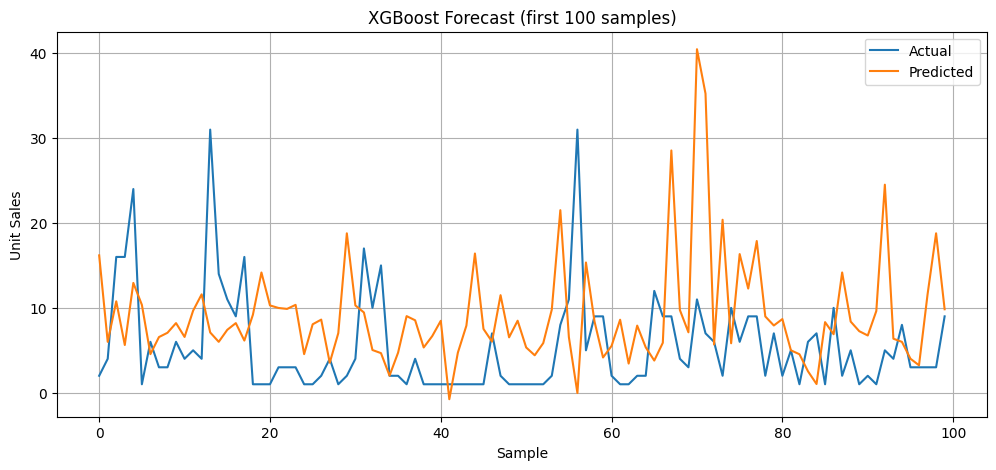

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_xgb.values[:100], label='Actual')
plt.plot(y_pred_xgb[:100], label='Predicted')
plt.title('XGBoost Forecast (first 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()


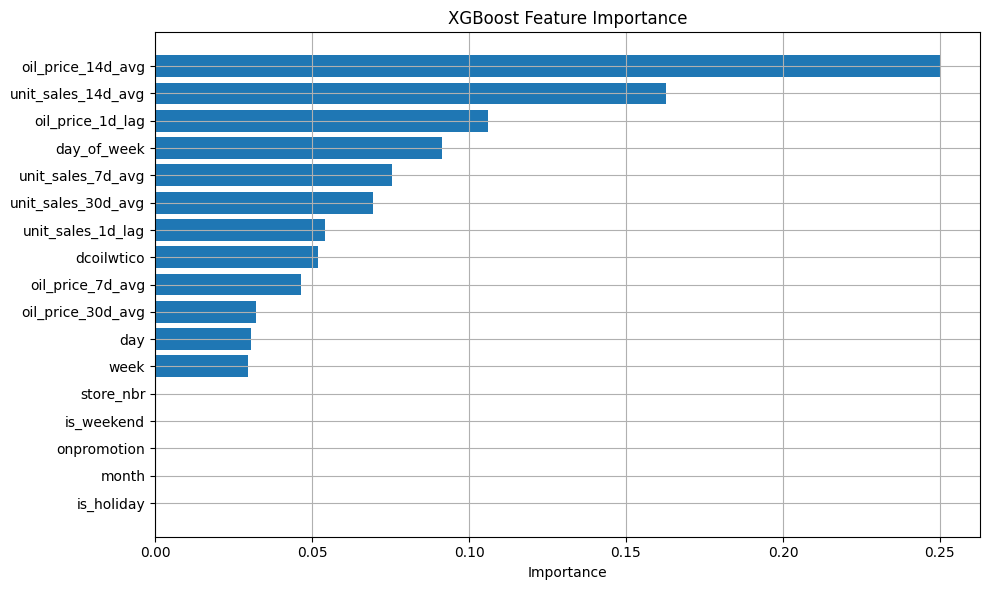

In [42]:
# ================== Feature Importance: XGBoost ==================
importances = model_xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# ================== LSTM Forecast ==================
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [29]:
X_scaled_lstm = scaler_x.fit_transform(xgb_df[features])
y_scaled_lstm = scaler_y.fit_transform(xgb_df['unit_sales'].values.reshape(-1, 1))

window_size = 30

In [30]:
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(target) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y).reshape(-1, 1)


In [31]:
X_lstm, y_lstm = create_sequences(X_scaled_lstm, y_scaled_lstm, window_size)
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]


In [39]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(window_size, X_lstm.shape[2])))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_lstm.fit(X_train_lstm, y_train_lstm,
               validation_data=(X_test_lstm, y_test_lstm),
               epochs=20, batch_size=32,
               callbacks=[early_stop], verbose=1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0052 - val_loss: 4.5156e-04
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0044 - val_loss: 8.2559e-04
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0030 - val_loss: 5.2596e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0022 - val_loss: 5.3921e-04


In [40]:
y_pred_scaled_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm)
y_true_lstm = scaler_y.inverse_transform(y_test_lstm)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


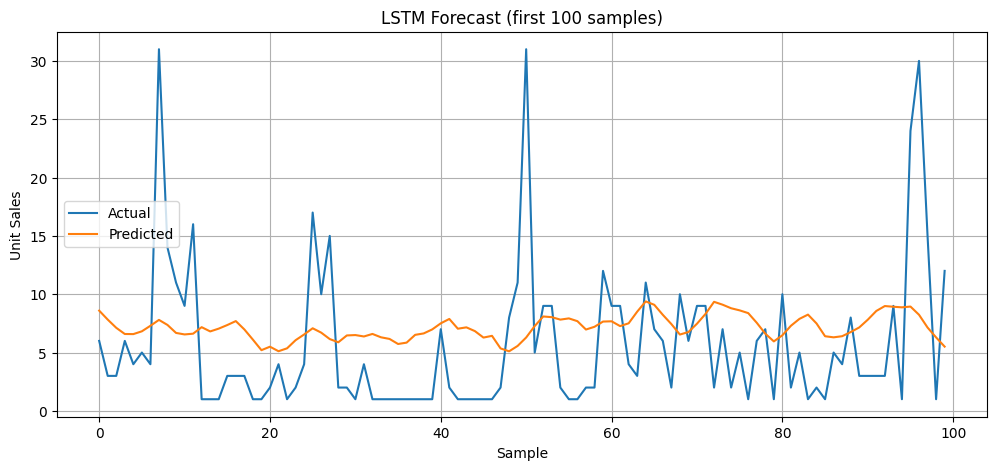

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_lstm[:100], label='Actual')
plt.plot(y_pred_lstm[:100], label='Predicted')
plt.title('LSTM Forecast (first 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

def lstm_feature_importance(model, X_test, y_test, scaler_y, feature_names):
    # Flatten to 2D input for permutation (window collapsed)
    X_flat = X_test.reshape((X_test.shape[0], -1))
    y_pred_flat = scaler_y.inverse_transform(model.predict(X_test))
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred_flat)

    importances = []
    for i in range(X_flat.shape[1]):
        X_permuted = X_flat.copy()
        np.random.shuffle(X_permuted[:, i])
        X_permuted_seq = X_permuted.reshape(X_test.shape)
        y_permuted_pred = scaler_y.inverse_transform(model.predict(X_permuted_seq))
        mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_permuted_pred)
        importances.append(mse - baseline_mse)

    avg_importance = np.array(importances).reshape(window_size, -1).mean(axis=0)
    sorted_idx = np.argsort(avg_importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], avg_importance[sorted_idx])
    plt.gca().invert_yaxis()
    plt.title('LSTM Feature Importance (Permutation Approx.)')
    plt.xlabel('Approx. Importance (ΔMSE)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

lstm_feature_importance(model_lstm, X_test_lstm, y_test_lstm, scaler_y, features)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
